# Step 1 | Setup and Initialization

## Step 1.1 | Importing Necessary Libraries

In [110]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from joblib import dump
from sklearn.preprocessing import StandardScaler

## Step 1.2 | Loading the Dataset

In [111]:
Customers_df = pd.read_csv('../data/Customers.csv', sep=';')
Orders_df = pd.read_csv('../data/Orders.csv', sep=';')
Products_df = pd.read_csv('../data/Products.csv', sep=';')
USA_Sales_df = pd.read_csv('../data/USA_Sales.csv', sep=';')

In [112]:
Customers_df.head(10)

,Customer_ID,First_Name,Last_Name,Postal_Code,City,Country,Score
0,1,Bill,Van Buren,78000,Versailles,France,76
1,2,Gerald,Jackson,60528,Frankfurt a.M.,Germany,74
2,3,Harry,Nixon,75016,Paris,France,3
3,4,Dwight,Coolidge,97219,Portland,USA,25
4,5,Rutherford,Roosevelt,4179,Leipzig,Germany,87
5,6,Grover,Grant,80805,München,Germany,65
6,7,Grover,Roosevelt,98128,Seattle,USA,24
7,8,Bill,Roosevelt,82520,Lander,USA,27
8,9,Calvin,McKinley,97201,Portland,USA,54
9,10,Dwight,Jefferson,78000,Versailles,France,50


In [113]:
Orders_df.head(5)

,Order_ID,Customer_ID,Product_ID,Order_Date,Shipping_Date,Sales,Quantity,Discount,Profit,Unit_Price
0,1,89,1566,29/03/2019,04/04/2019,79.4000,5,0.20,5.9550,15.6800
1,2,244,343,14/07/2019,23/07/2019,375.4575,3,0.45,-157.0095,124.7025
2,3,291,558,01/02/2019,18/02/2019,23.7600,3,0.20,2.0790,7.7200
3,4,613,1135,13/03/2019,23/03/2019,142.4000,5,0.00,52.6880,28.4800
4,5,390,641,15/10/2019,02/11/2019,94.8500,5,0.00,45.5280,18.9700


In [114]:
Products_df.head(5)

,Product_ID,Product_Name,Category,Sub_Category
0,1,Bush Somerset Collection Bookcase,Furniture,Bookcases
1,2,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs
2,3,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels
3,4,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables
4,5,Eldon Fold 'N Roll Cart System,Office Supplies,Storage


## Step 1.3 | Create Label

In [115]:
today = date.today()
print(today)

Orders_df['Time_Since_Order'] = Orders_df["Order_Date"].apply(lambda x: (today - datetime.strptime(x, "%d/%m/%Y").date()).days)
Orders_df['Time_Since_Order']

2024-05-14


0        1873
1        1766
2        1929
3        1889
4        1673
         ... 
11802    2160
11803    2148
11804    2269
11805    2300
11806    2071
Name: Time_Since_Order, Length: 11807, dtype: int64

In [116]:
Orders_df

,Order_ID,Customer_ID,Product_ID,Order_Date,Shipping_Date,Sales,Quantity,Discount,Profit,Unit_Price,Time_Since_Order
0,1,89,1566,29/03/2019,04/04/2019,79.4000,5,0.20,5.9550,15.6800,1873
1,2,244,343,14/07/2019,23/07/2019,375.4575,3,0.45,-157.0095,124.7025,1766
2,3,291,558,01/02/2019,18/02/2019,23.7600,3,0.20,2.0790,7.7200,1929
3,4,613,1135,13/03/2019,23/03/2019,142.4000,5,0.00,52.6880,28.4800,1889
4,5,390,641,15/10/2019,02/11/2019,94.8500,5,0.00,45.5280,18.9700,1673
...,...,...,...,...,...,...,...,...,...,...,...
11802,11803,327,1136,15/06/2018,19/06/2018,1127.9760,3,0.20,126.8973,375.7920,2160
11803,11804,535,912,27/06/2018,05/07/2018,18.9000,3,0.00,8.6940,6.3000,2148
11804,11805,425,264,26/02/2018,28/03/2018,10.2300,3,0.00,4.9104,3.4100,2269
11805,11806,76,1135,26/01/2018,23/02/2018,142.4000,5,0.00,52.6880,28.4800,2300


In [117]:
label_df = Orders_df.copy()
# Group by 'Customer_ID' và tính giá trị nhỏ nhất của 'Time_Since_Order' cho mỗi nhóm
label_df['Oldest_Order_Date'] = Orders_df.groupby('Customer_ID')['Time_Since_Order'].transform('min')

label_df['Around2month'] = label_df.apply(lambda row: 1 if (row['Time_Since_Order'] - row['Oldest_Order_Date']) < 60 else 0, axis=1)

In [118]:
label_df.loc[label_df['Customer_ID'] == 89]

,Order_ID,Customer_ID,Product_ID,Order_Date,Shipping_Date,Sales,Quantity,Discount,Profit,Unit_Price,Time_Since_Order,Oldest_Order_Date,Around2month
0,1,89,1566,29/03/2019,04/04/2019,79.400,5,0.2,5.9550,15.680,1873,508,0
35,36,89,986,08/01/2019,05/02/2019,149.950,5,0.0,44.9850,29.990,1953,508,0
337,338,89,3,01/10/2019,13/10/2019,58.480,8,0.0,27.4856,7.310,1687,508,0
795,796,89,1386,24/09/2019,25/09/2019,2154.900,5,0.0,129.2940,430.980,1694,508,0
1356,1357,89,554,07/08/2019,18/08/2019,70.970,5,0.8,-191.6190,13.394,1742,508,0
1434,1435,89,1451,10/07/2019,24/07/2019,188.552,7,0.3,-2.6936,26.636,1770,508,0
2571,2572,89,1560,30/08/2020,20/09/2020,4.608,2,0.2,1.4976,2.104,1353,508,0
3196,3197,89,199,24/06/2020,28/06/2020,52.000,4,0.0,23.4000,13.000,1420,508,0
4171,4172,89,396,06/03/2021,02/04/2021,113.372,2,0.3,-29.1528,56.386,1165,508,0
4784,4785,89,1729,30/11/2021,17/12/2021,1640.700,5,0.0,459.3960,328.140,896,508,0


In [119]:
label_df = label_df.loc[label_df['Around2month'] == 1]
Orders_df = Orders_df.loc[~Orders_df['Order_ID'].isin(label_df['Order_ID'])]

In [120]:
Orders_df.shape

(10371, 11)

In [121]:
label_df.shape

(1436, 13)

In [122]:
label = label_df[['Customer_ID', 'Sales']]
label

,Customer_ID,Sales
3706,122,637.440
3733,493,4.470
3748,150,478.240
4047,347,25.060
4071,150,175.230
...,...,...
10658,345,5.560
10659,688,139.800
10662,110,9.780
10666,565,6.384


In [123]:
label = label.groupby('Customer_ID').sum().reset_index()

In [124]:
label.loc[label['Customer_ID'] == 89]

,Customer_ID,Sales
88,89,795.76


## Step 1.4 | Create feature

In [125]:
col = ['Customer_ID', 
       'Total_Order_Value', 
       'Total_Order_Count', 
       'Time_Sine_Last_Order', 
       'Average_Order_Value', 
       'Product_Diversity', 
       # 'Most_Common_Product_Category', 
       'Total_Products_Purchased', 
       'Average_Time_Between_Orders', 
       'Recent_Product_Category', 
       'Geographic', 
       'Marketing',
       'Score']
feature_df = pd.DataFrame(columns=col)

In [126]:
feature_df

,Customer_ID,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score


In [127]:
feature_df['Customer_ID'] = Customers_df['Customer_ID']

# Step 2 | Data overview

In [128]:
Orders_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Order_ID,10371.0,5519.509016,3437.927720,1.000,2593.500,5197.000,8372.5000,11807.000
Customer_ID,10371.0,399.656446,230.717311,1.000,200.000,401.000,600.0000,800.000
Product_ID,10371.0,824.853245,513.712099,1.000,375.500,798.000,1247.5000,1850.000
Sales,10371.0,240.649004,719.745523,0.444,17.544,53.720,209.9400,22638.480
Quantity,10371.0,3.935011,2.341776,1.000,2.000,3.000,5.0000,14.000
Discount,10371.0,0.162972,0.211357,0.000,0.000,0.200,0.2000,0.800
Profit,10371.0,25.032776,238.392265,-6599.978,1.512,8.502,28.8576,8399.976
Unit_Price,10371.0,60.830858,156.389473,-0.464,5.280,15.672,62.2300,3772.580
Time_Since_Order,10371.0,1274.098930,465.175800,562.000,879.500,1188.000,1600.0000,2325.000


In [129]:
# Summary statistics for categorical variables
Orders_df.describe(include='object').T

,count,unique,top,freq
Order_Date,10371,1725,13/01/2022,19
Shipping_Date,10371,1736,24/02/2022,23


# Step 3 | Data clearning & Transform 

## Step 3.1 | Handling missing value 

In [130]:
Orders_df.isna().sum()  

Order_ID            0
Customer_ID         0
Product_ID          0
Order_Date          0
Shipping_Date       0
Sales               0
Quantity            0
Discount            0
Profit              0
Unit_Price          0
Time_Since_Order    0
dtype: int64

In [131]:
Orders_df.duplicated().sum()

0

# Step 4 | Feature Engineering

## Step 4.1 | Calculate the total value of all orders that each customer has made in the past

In [132]:
Total_Order_Value = Orders_df.groupby('Customer_ID')['Sales'].sum()
print(Total_Order_Value)


Customer_ID
1      2885.1220
2       972.5000
3      4566.1940
4      1966.9300
5      2129.3220
         ...    
796    1264.9440
797    5883.6086
798    4837.1050
799    1179.3950
800    3440.0340
Name: Sales, Length: 800, dtype: float64


In [133]:
feature_df['Total_Order_Value'] = Total_Order_Value.values


## Step 4.2 | Count the number of order

In [134]:
Total_Order_Count = Orders_df.groupby('Customer_ID')['Order_ID'].count()
print(Total_Order_Count)

Customer_ID
1      14
2      11
3      16
4      11
5      16
       ..
796    12
797    16
798    11
799    11
800    21
Name: Order_ID, Length: 800, dtype: int64


In [135]:
feature_df['Total_Order_Count'] = Total_Order_Count.values

## Step 4.3 | Caculate time since last order 

In [136]:
Time_Sine_Last_Order = Orders_df.groupby('Customer_ID')['Time_Since_Order'].min()

In [137]:
Time_Sine_Last_Order

Customer_ID
1      800
2      730
3      645
4      707
5      648
      ... 
796    574
797    606
798    686
799    632
800    633
Name: Time_Since_Order, Length: 800, dtype: int64

In [138]:
feature_df['Time_Sine_Last_Order'] = Time_Sine_Last_Order.values

## Step 4.4 Caculate the average value of the pass orders

In [139]:
feature_df['Average_Order_Value'] = feature_df['Total_Order_Value'] / feature_df['Total_Order_Count']

## Step 4.5 | Caculate Product Diversity

In [140]:
Product_Diversity = Orders_df.groupby('Customer_ID')['Product_ID'].nunique()

In [141]:
Product_Diversity

Customer_ID
1      14
2      11
3      16
4      11
5      16
       ..
796    12
797    16
798    11
799    11
800    21
Name: Product_ID, Length: 800, dtype: int64

In [142]:
feature_df['Product_Diversity'] = Product_Diversity.values

## Step 4.6 | Count number of product

In [143]:
Total_Products_Purchased = Orders_df.groupby('Customer_ID')['Quantity'].sum()

In [144]:
Total_Products_Purchased

Customer_ID
1      60
2      35
3      62
4      42
5      54
       ..
796    32
797    64
798    59
799    46
800    73
Name: Quantity, Length: 800, dtype: int64

In [145]:
feature_df['Total_Products_Purchased'] = Total_Products_Purchased.values

## Step 4.7 | Average the time intervals between purchases

In [146]:
Time_Sine_Oldest_Order = Orders_df.groupby('Customer_ID')['Time_Since_Order'].max()

In [147]:
feature_df['Average_Time_Between_Orders'] = Time_Sine_Oldest_Order.values / feature_df['Total_Order_Count']

## Step 4.8 | Recent Product Category

In [148]:
min_time_orders = Orders_df.groupby('Customer_ID')['Time_Since_Order'].idxmin()
product_ids = Orders_df.loc[min_time_orders, ['Customer_ID', 'Product_ID', "Discount"]]
product_ids

,Customer_ID,Product_ID,Discount
9902,1,985,0.3
10399,2,677,0.2
9573,3,1800,0.8
7117,4,54,0.2
9664,5,236,0.0
...,...,...,...
9708,796,212,0.2
7573,797,971,0.0
8051,798,419,0.0
9650,799,701,0.0


In [149]:
product_ids_indexed = product_ids.set_index('Customer_ID')
feature_df['Recent_Product_Category'] = feature_df['Customer_ID'].map(product_ids_indexed['Product_ID'])

## Step 4.9 | Maketing for Recent Product Category

In [150]:
product_ids_indexed

,Product_ID,Discount
Customer_ID,,
1,985,0.3
2,677,0.2
3,1800,0.8
4,54,0.2
5,236,0.0
...,...,...
796,212,0.2
797,971,0.0
798,419,0.0


In [151]:
product_ids_indexed = product_ids.set_index('Customer_ID')
feature_df['Marketing'] = feature_df['Customer_ID'].map(product_ids_indexed['Discount'])

## Step 4.10 | Seasonality & Trends

* Monthly_Spending_Mean: This is the average amount a customer spends monthly. 
* Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending.
* Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data.

In [152]:
# Extract month and year from 'Order_Date'
Orders_df['Year'] = Orders_df['Order_Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").year)
Orders_df['Month'] = Orders_df['Order_Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").month)

# Caculate monthlly spendings for each customer
monthly_spending = Orders_df.groupby(['Customer_ID', 'Year', 'Month'])['Sales'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('Customer_ID')['Sales'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('Customer_ID')['Sales'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Sales': 'Spending_Trend'}, inplace=True)

# Merge the new features into the feature_df dataframe
feature_df = pd.merge(feature_df, seasonal_buying_patterns, on='Customer_ID')
feature_df = pd.merge(feature_df, spending_trends, on='Customer_ID')

# Display the first few rows of the feature_df dataframe
feature_df.head()

C:\Users\anhdu\AppData\Local\Temp\ipykernel_12736\3979987441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Orders_df['Year'] = Orders_df['Order_Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").year)
C:\Users\anhdu\AppData\Local\Temp\ipykernel_12736\3979987441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Orders_df['Month'] = Orders_df['Order_Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").month)


,Customer_ID,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,1,2885.122,14,800,206.080143,14,60,149.642857,985,NaN,0.3,NaN,262.283818,293.270199,3.282091
1,2,972.500,11,730,88.409091,11,35,190.545455,677,NaN,0.2,NaN,97.250000,99.242670,3.596533
2,3,4566.194,16,645,285.387125,16,62,141.062500,1800,NaN,0.8,NaN,351.245692,362.173152,-10.961626
3,4,1966.930,11,707,178.811818,11,42,175.090909,54,NaN,0.2,NaN,196.693000,336.999493,58.458121
4,5,2129.322,16,648,133.082625,16,54,123.187500,236,NaN,0.0,NaN,177.443500,189.411686,-1.847210


## Step 4.11 | Geography & Score

In [153]:
Customers_df_indexed = Customers_df.set_index('Customer_ID')
feature_df['Geographic'] = feature_df['Customer_ID'].map(Customers_df_indexed['Postal_Code'])
feature_df['Score'] = feature_df['Customer_ID'].map(Customers_df_indexed['Score'])

In [154]:
feature_df

,Customer_ID,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,1,2885.1220,14,800,206.080143,14,60,149.642857,985,78000,0.3,76,262.283818,293.270199,3.282091
1,2,972.5000,11,730,88.409091,11,35,190.545455,677,60528,0.2,74,97.250000,99.242670,3.596533
2,3,4566.1940,16,645,285.387125,16,62,141.062500,1800,75016,0.8,3,351.245692,362.173152,-10.961626
3,4,1966.9300,11,707,178.811818,11,42,175.090909,54,97219,0.2,25,196.693000,336.999493,58.458121
4,5,2129.3220,16,648,133.082625,16,54,123.187500,236,4179,0.0,87,177.443500,189.411686,-1.847210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,1264.9440,12,574,105.412000,12,32,185.000000,212,97201,0.2,79,126.494400,258.066290,32.136291
796,797,5883.6086,16,606,367.725538,16,64,118.875000,971,97219,0.0,0,452.585277,780.773863,110.183758
797,798,4837.1050,11,686,439.736818,11,59,176.454545,419,13008,0.0,20,439.736818,685.354600,17.736700
798,799,1179.3950,11,632,107.217727,11,46,198.363636,701,78000,0.0,59,117.939500,178.250199,30.121242


In [155]:
feature_df.isna().sum() 

Customer_ID                    0
Total_Order_Value              0
Total_Order_Count              0
Time_Sine_Last_Order           0
Average_Order_Value            0
Product_Diversity              0
Total_Products_Purchased       0
Average_Time_Between_Orders    0
Recent_Product_Category        0
Geographic                     0
Marketing                      0
Score                          0
Monthly_Spending_Mean          0
Monthly_Spending_Std           0
Spending_Trend                 0
dtype: int64

# Step 5 | Outline Detction and Treatment

In this section, I will identify and handle outliers in our dataset. Outliers are data points that are significantly different from the majority of other points in the dataset. These points can potentially skew the results of our analysis, especially in k-means clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.

In [156]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
feature_df['Outlier_Scores'] = model.fit_predict(feature_df.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
feature_df['Is_Outlier'] = [1 if x == -1 else 0 for x in feature_df['Outlier_Scores']]

# Display the first few rows of the feature_df dataframe
feature_df.head()

,Customer_ID,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,1,2885.122,14,800,206.080143,14,60,149.642857,985,78000,0.3,76,262.283818,293.270199,3.282091,1,0
1,2,972.500,11,730,88.409091,11,35,190.545455,677,60528,0.2,74,97.250000,99.242670,3.596533,1,0
2,3,4566.194,16,645,285.387125,16,62,141.062500,1800,75016,0.8,3,351.245692,362.173152,-10.961626,1,0
3,4,1966.930,11,707,178.811818,11,42,175.090909,54,97219,0.2,25,196.693000,336.999493,58.458121,1,0
4,5,2129.322,16,648,133.082625,16,54,123.187500,236,4179,0.0,87,177.443500,189.411686,-1.847210,1,0


In [157]:
feature_df['Is_Outlier'].value_counts()

Is_Outlier
0    760
1     40
Name: count, dtype: int64

In [158]:
feature_df_outline = feature_df.loc[feature_df['Is_Outlier'] == 1]
feature_df_outline

,Customer_ID,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
8,9,14588.6172,25,581,583.544688,25,102,76.120000,404,97201,0.2,54,729.430860,2316.547512,-55.332946,-1,1
10,11,13154.0950,19,586,692.320789,19,74,104.894737,184,75016,0.0,50,876.939667,2532.096084,-173.452143,-1,1
32,33,11877.8240,8,717,1484.728000,8,35,283.625000,1375,69004,0.0,88,1484.728000,3645.800302,886.094762,-1,1
40,41,2946.7720,3,1556,982.257333,3,23,721.000000,1138,80805,0.0,33,982.257333,811.401587,595.729000,-1,1
47,48,6593.2640,11,1016,599.387636,11,51,210.000000,31,42100,0.0,69,659.326400,1503.690668,193.962012,-1,1
55,56,3299.3560,7,1326,471.336571,7,29,303.000000,138,68306,0.2,37,549.892667,1072.789338,-371.838514,-1,1
57,58,24218.4500,15,661,1614.563333,15,59,153.733333,1387,44000,0.0,72,1729.889286,6019.493143,436.696611,-1,1
81,82,26240.9880,14,646,1874.356286,14,65,160.857143,504,97403,0.2,16,2186.749000,6456.396714,336.844182,-1,1
147,148,10333.6280,11,659,939.420727,11,44,198.181818,715,12209,0.7,69,1291.703500,3300.935803,344.597190,-1,1
149,150,11915.2520,10,1114,1191.525200,9,40,230.400000,1002,97403,0.0,58,1323.916889,3010.290837,-712.597800,-1,1


In [159]:
feature_df = feature_df.loc[feature_df['Is_Outlier'] == 0]

# Step 6 | Corelation Analysis

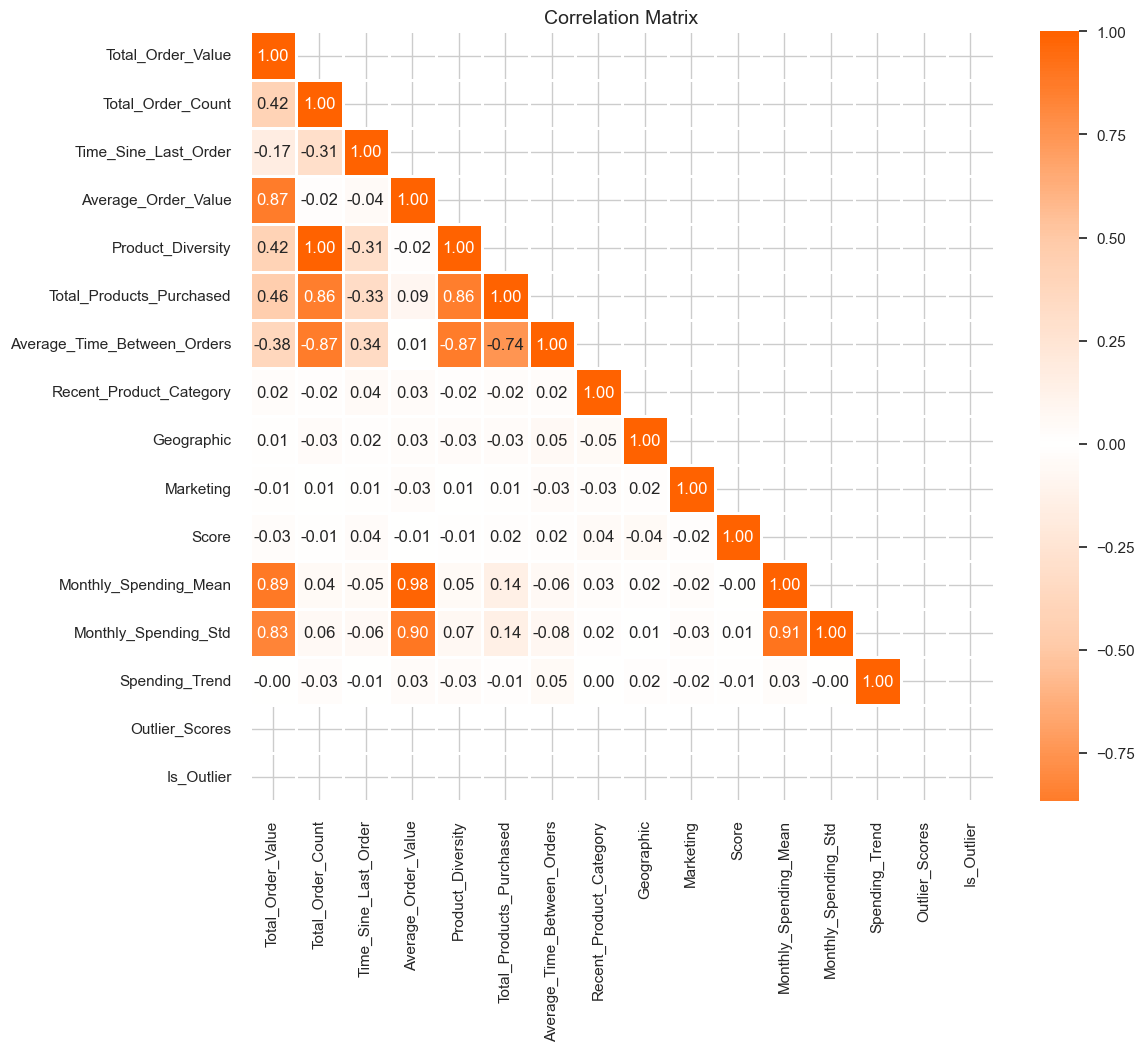

In [160]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = feature_df.drop(columns=['Customer_ID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

**Inference:**
Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

* Average_Order_Value and Total_Order_Value
* Product_Diversity and Total_Order_Count
* Total_Products_Purchased and Total_Order_Count
* Average_Time_Between_Orders and Total_Order_Count
* Monthly_Spending_mean and Total_Order_Value
* Monthly_Spending_std and Average_Order_Value
* Monthly_Spending_mean and Average_Order_Value
* Monthly_Spending_std and Total_Order_Value

The reason may be because customers often buy a product at once and there is no repetition for that item.

These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

# Step 7 | Feature Scaling

In [106]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['Customer_ID', 'Recent_Product_Category', 'Geographic', 'Is_Outlier', 'Outlier_Scores']

# List of columns that need to be scaled
columns_to_scale = feature_df.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = feature_df.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

dump(scaler, 'scaler.joblib')

# Display the first few rows of the scaled data
customer_data_scaled.head()

,Customer_ID,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,1,0.042644,0.271482,0.989767,-0.082460,0.288856,0.537863,-0.441799,985,78000,0.646078,0.997933,0.107859,-0.334125,-0.028563,1,0
1,2,-1.059871,-0.572965,0.280171,-1.028848,-0.558753,-0.983108,0.380609,677,60528,0.174579,0.932214,-1.039936,-0.968698,-0.023025,1,0
2,3,1.011684,0.834447,-0.581482,0.555379,0.853929,0.659541,-0.614320,1800,75016,3.003573,-1.400807,0.726581,-0.108776,-0.279433,1,0
3,4,-0.486640,-0.572965,0.047017,-0.301770,-0.558753,-0.557236,0.069872,54,97219,0.174579,-0.677899,-0.348319,-0.191107,0.943233,1,0
4,5,-0.393031,0.834447,-0.551071,-0.669554,0.853929,0.172830,-0.973723,236,4179,-0.768419,1.359387,-0.482198,-0.673797,-0.118904,1,0


# Step 8 | Dimensionality Reduction

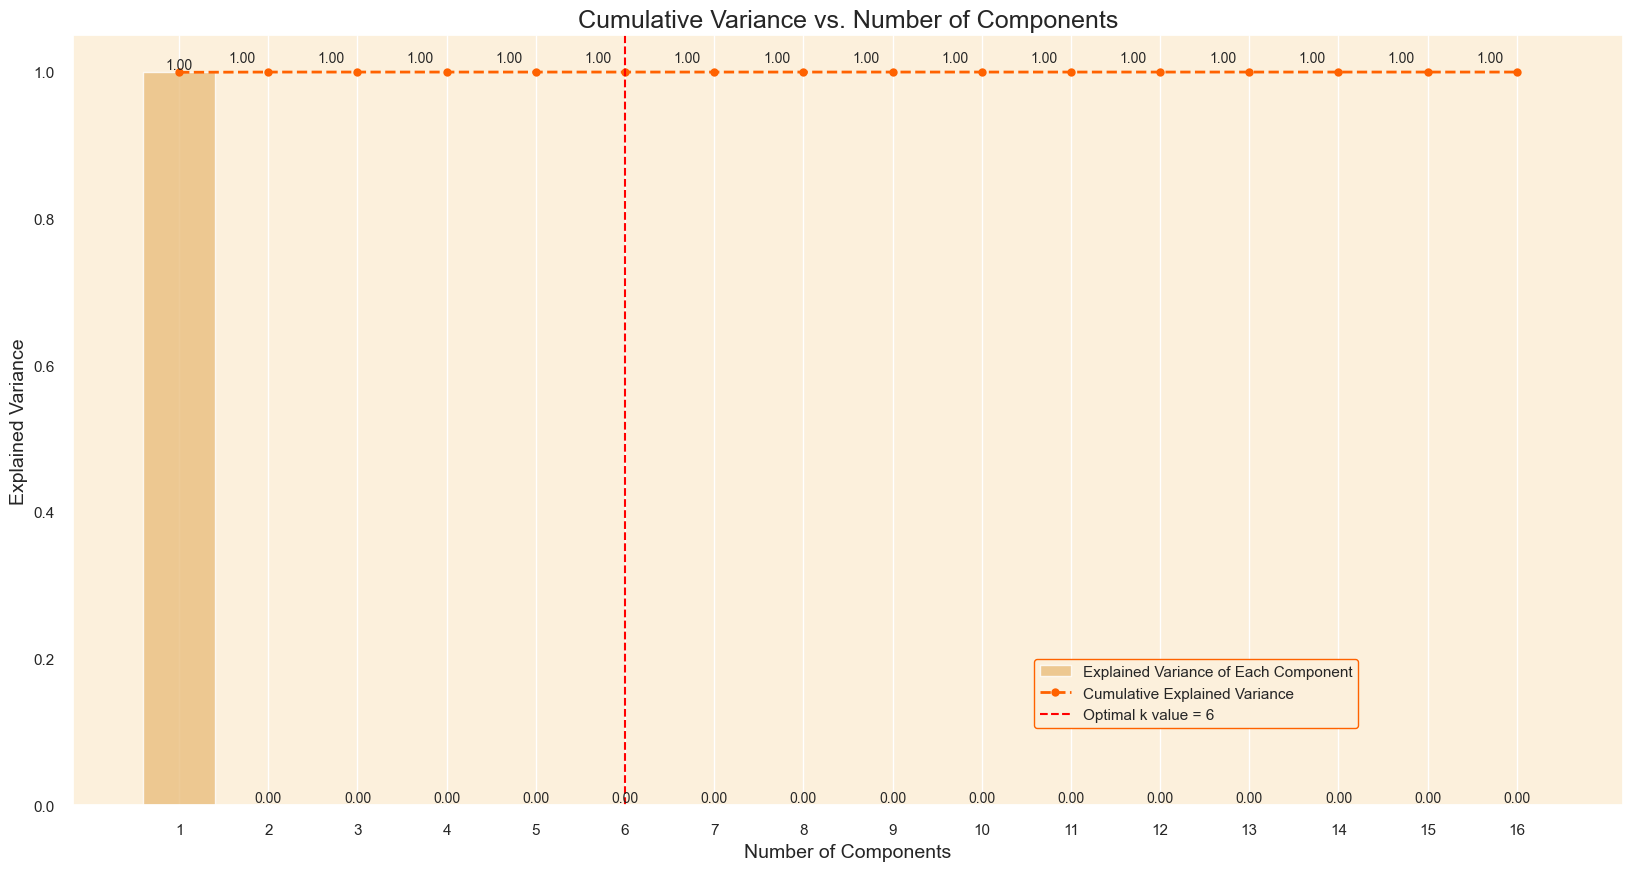

In [107]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('Customer_ID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [108]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [109]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
Customer_ID,,,,,,
1,-15317.795891,199.224352,0.328668,-0.534087,-0.476491,0.913748
2,2153.939124,-123.457389,-2.322270,-0.710788,-0.000629,0.740888
3,-12333.112100,1011.716214,1.984677,-0.520773,-2.551128,-1.946531
4,-34537.571435,-715.625585,-1.075482,0.116190,0.437452,-0.931343
5,58502.548663,-611.807657,0.318286,-1.586643,0.759111,1.282724


# Step 10 | Save label and feature 

In [166]:
label.rename(columns={'Sales': 'Expected_Sales'}, inplace=True)
customer_data_scaled = pd.merge(customer_data_scaled, label, on='Customer_ID', how='left')

In [167]:
customer_data_scaled.to_csv('train_data.csv', index=False)


In [168]:
customer_data_scaled.head()

,Customer_ID,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier,Expected_Sales
0,1,0.042644,0.271482,0.989767,-0.082460,0.288856,0.537863,-0.441799,985,78000,0.646078,0.997933,0.107859,-0.334125,-0.028563,1,0,883.324
1,2,-1.059871,-0.572965,0.280171,-1.028848,-0.558753,-0.983108,0.380609,677,60528,0.174579,0.932214,-1.039936,-0.968698,-0.023025,1,0,58.240
2,3,1.011684,0.834447,-0.581482,0.555379,0.853929,0.659541,-0.614320,1800,75016,3.003573,-1.400807,0.726581,-0.108776,-0.279433,1,0,189.510
3,4,-0.486640,-0.572965,0.047017,-0.301770,-0.558753,-0.557236,0.069872,54,97219,0.174579,-0.677899,-0.348319,-0.191107,0.943233,1,0,308.938
4,5,-0.393031,0.834447,-0.551071,-0.669554,0.853929,0.172830,-0.973723,236,4179,-0.768419,1.359387,-0.482198,-0.673797,-0.118904,1,0,352.232
